In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 4)

# --- ŚCIEŻKI DO PLIKÓW ---
DATA_DIR = Path("data/daneInternet")
HEALTHY_PATH = DATA_DIR / "Healthy.xlsx"
DAMAGED_PATH = DATA_DIR / "Damaged Bottom Right Blade.xlsx"

# --- WYBRANY FRAGMENT CZASU [s] ---
T_START = 50.0   # początek okna
T_END   = 100.0   # koniec okna

def load_case(path: Path) -> pd.DataFrame:
    """Wczytuje plik Excela i porządkuje nazwy kolumn."""
    df = pd.read_excel(path)
    df.columns = [c.strip() for c in df.columns]
    # ujednolicamy nazwy, żeby dalej było wygodnie
    df = df.rename(columns={
        "Time (s)": "time",
        "X Acceleration": "ax",
        "Y Acceleration": "ay",
        "Z Acceleration": "az",
    })
    return df

def cut_segment(df: pd.DataFrame, t_start: float, t_end: float):
    """Zwraca fragment sygnału między t_start i t_end (w sekundach) + Fs."""
    mask = (df["time"] >= t_start) & (df["time"] <= t_end)
    seg = df.loc[mask].reset_index(drop=True)
    t = seg["time"].values
    dt = np.mean(np.diff(t))
    Fs = 1.0 / dt
    return seg, Fs

# --- Wczytanie pełnych danych ---
df_healthy_full = load_case(HEALTHY_PATH)
df_damaged_full = load_case(DAMAGED_PATH)

# --- Przycięcie do zadanego okna czasu ---
seg_healthy, Fs_h = cut_segment(df_healthy_full, T_START, T_END)
seg_damaged, Fs_d = cut_segment(df_damaged_full, T_START, T_END)

print(f"Wybrany fragment: {T_START}–{T_END} s")
print(f"Healthy:  {len(seg_healthy)} próbek, Fs ≈ {Fs_h:.2f} Hz")
print(f"Damaged:  {len(seg_damaged)} próbek, Fs ≈ {Fs_d:.2f} Hz")

# Na wygodę: krótkie aliasy na później
t_h, x_h = seg_healthy["time"].values, seg_healthy["ax"].values
t_d, x_d = seg_damaged["time"].values, seg_damaged["ax"].values


Wybrany fragment: 50.0–100.0 s
Healthy:  47292 próbek, Fs ≈ 945.83 Hz
Damaged:  47447 próbek, Fs ≈ 948.93 Hz


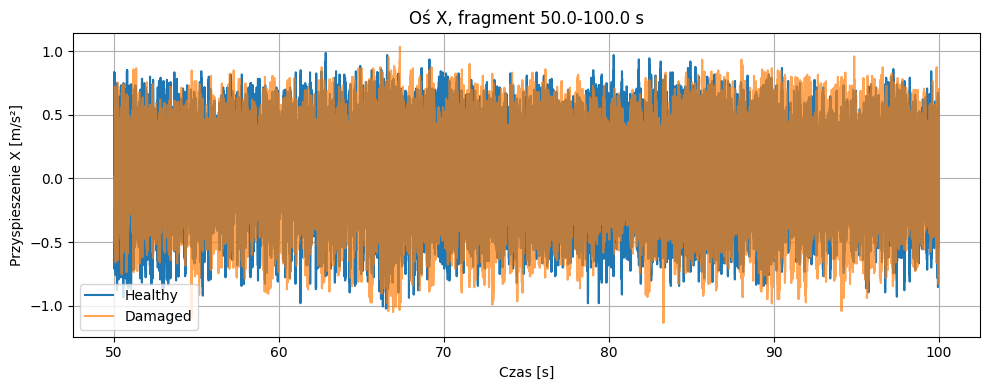

In [4]:
plt.figure()
plt.plot(t_h, x_h, label="Healthy")
plt.plot(t_d, x_d, label="Damaged", alpha=0.7)
plt.xlabel("Czas [s]")
plt.ylabel("Przyspieszenie X [m/s²]")
plt.title(f"Oś X, fragment {T_START}-{T_END} s")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


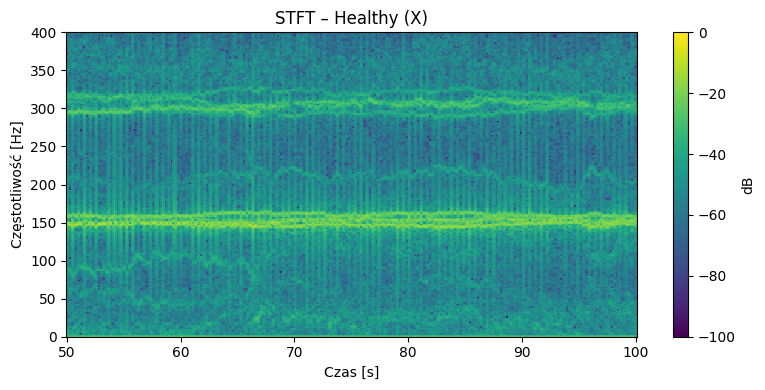

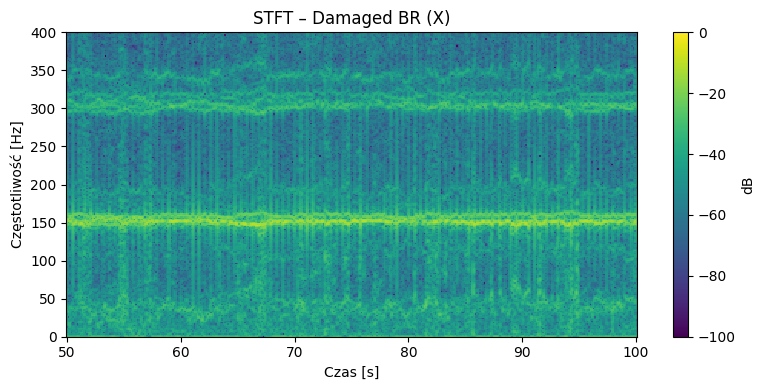

In [5]:
from scipy.signal import stft

def plot_stft(t, x, Fs, title, fmax=400):
    f, tt, Z = stft(x, fs=Fs, window="hann", nperseg=512, noverlap=384)
    Z_db = 20 * np.log10(np.abs(Z) + 1e-12)

    plt.figure(figsize=(8, 4))
    plt.pcolormesh(tt + t[0], f, Z_db, shading="auto", vmin=-100, vmax=0)
    plt.ylim(0, fmax)
    plt.xlabel("Czas [s]")
    plt.ylabel("Częstotliwość [Hz]")
    plt.title(title)
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()

plot_stft(t_h, x_h, Fs_h, "STFT – Healthy (X)")
plot_stft(t_d, x_d, Fs_d, "STFT – Damaged BR (X)")


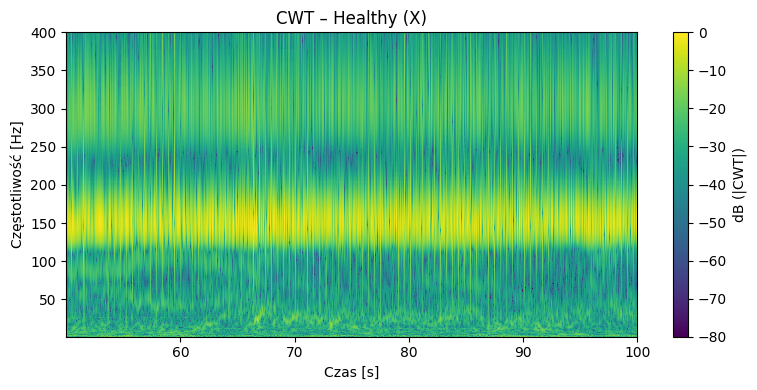

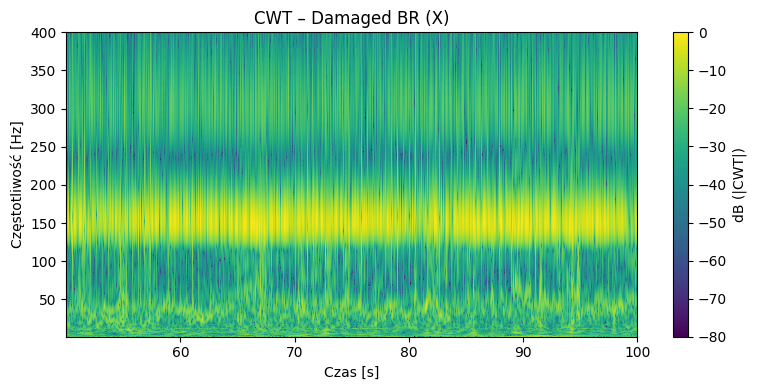

In [38]:
import pywt

def compute_cwt_freq(t, x, Fs, fmin, fmax, n_freqs=300,
                     wavelet="cmor3.5-1.0"):
    """
    Liczy CWT i zwraca:
    - freqs: wektor częstotliwości [Hz] (n_freqs,)
    - power_db: macierz dB o kształcie (n_freqs, len(t))
    """
    dt = 1.0 / Fs

    freqs = np.linspace(fmin, fmax, n_freqs)
    scales = pywt.frequency2scale(wavelet, freqs * dt)

    coeffs, _ = pywt.cwt(x, scales, wavelet, sampling_period=dt)
    power = np.abs(coeffs)
    power_db = 20 * np.log10(power + 1e-12)

    return freqs, power_db

def plot_cwt_from_power(t, freqs, power_db, title,
                        vmin=-80, vmax=0, fmin=None, fmax=None):
    if fmin is None:
        fmin = freqs.min()
    if fmax is None:
        fmax = freqs.max()

    plt.figure(figsize=(8, 4))
    plt.pcolormesh(t, freqs, np.clip(power_db, vmin, vmax),
                   shading="auto", vmin=vmin, vmax=vmax)
    plt.ylim(fmin, fmax)
    plt.xlabel("Czas [s]")
    plt.ylabel("Częstotliwość [Hz]")
    plt.title(title)
    plt.colorbar(label="dB (|CWT|)")
    plt.tight_layout()
    plt.show()

freqs_h, power_db_h = compute_cwt_freq(t_h, x_h, Fs_h, fmin=1, fmax=400)
freqs_d, power_db_d = compute_cwt_freq(t_d, x_d, Fs_d, fmin=1, fmax=400)

plot_cwt_from_power(t_h, freqs_h, power_db_h, "CWT – Healthy (X)")
plot_cwt_from_power(t_d, freqs_d, power_db_d, "CWT – Damaged BR (X)")



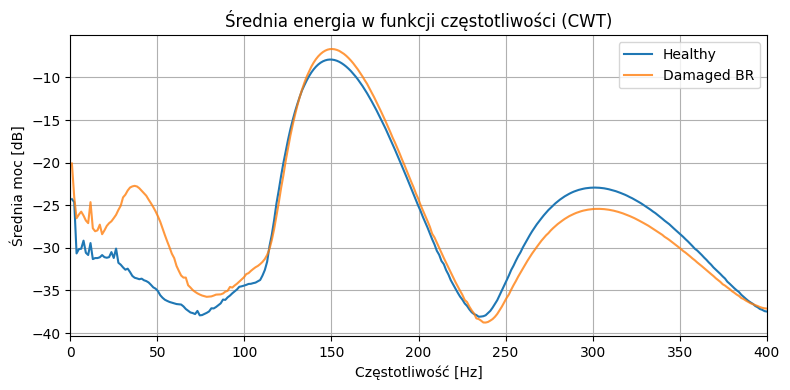

In [39]:
mean_h = power_db_h.mean(axis=1)   # średnia w czasie dla każdej częstotliwości
mean_d = power_db_d.mean(axis=1)

plt.figure(figsize=(8,4))
plt.plot(freqs_h, mean_h, label="Healthy")
plt.plot(freqs_d, mean_d, label="Damaged BR", alpha=0.8)
plt.xlim(0, 400)
plt.xlabel("Częstotliwość [Hz]")
plt.ylabel("Średnia moc [dB]")
plt.title("Średnia energia w funkcji częstotliwości (CWT)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
def band_energy(mean_spec, freqs, f1, f2):
    mask = (freqs >= f1) & (freqs <= f2)
    return mean_spec[mask].mean()

bands = [(50,80), (130,170), (260,340)]

for f1,f2 in bands:
    Eh = band_energy(mean_h, freqs_h, f1, f2)
    Ed = band_energy(mean_d, freqs_d, f1, f2)
    print(f"{f1}-{f2} Hz: healthy={Eh:.1f} dB, damaged={Ed:.1f} dB, różnica={Ed-Eh:+.1f} dB")


50-80 Hz: healthy=-36.9 dB, damaged=-32.5 dB, różnica=+4.4 dB
130-170 Hz: healthy=-9.4 dB, damaged=-8.5 dB, różnica=+0.9 dB
260-340 Hz: healthy=-24.7 dB, damaged=-27.1 dB, różnica=-2.4 dB


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from pathlib import Path

plt.rcParams["figure.figsize"] = (8, 4)

# --- ŚCIEŻKI ---
DATA_DIR = Path("data/daneInternet")
HEALTHY_PATH = DATA_DIR / "Healthy.xlsx"
DAMAGED_PATH = DATA_DIR / "Damaged Bottom Right Blade.xlsx"

def load_case(path: Path) -> pd.DataFrame:
    df = pd.read_excel(path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={
        "Time (s)": "time",
        "X Acceleration": "ax",
        "Y Acceleration": "ay",
        "Z Acceleration": "az",
    })
    return df

df_healthy = load_case(HEALTHY_PATH)
df_damaged = load_case(DAMAGED_PATH)

def extract_segment(df: pd.DataFrame, t_start: float, t_end: float):
    """Zwraca (t, x, Fs) dla fragmentu [t_start, t_end) w sekundach."""
    mask = (df["time"] >= t_start) & (df["time"] < t_end)
    seg = df.loc[mask].reset_index(drop=True)
    t = seg["time"].to_numpy()
    x = seg["ax"].to_numpy()
    dt = np.mean(np.diff(t))
    Fs = 1.0 / dt
    return t, x, Fs

# --- definicja okien czasowych ---
segments = [
    (50, 70),
    (70, 90),
    (90, 110),
    (110, 130),
    (130, 150),
]


In [3]:
import pywt

def compute_cwt_freq(x, Fs, fmin=1, fmax=400, n_freqs=300,
                     wavelet="cmor3.5-1.0"):
    """
    Liczy CWT i zwraca:
      freqs    – wektor częstotliwości [Hz] (n_freqs,)
      power_db – macierz dB o kształcie (n_freqs, len(x))
    """
    dt = 1.0 / Fs
    freqs = np.linspace(fmin, fmax, n_freqs)
    scales = pywt.frequency2scale(wavelet, freqs * dt)

    coeffs, _ = pywt.cwt(x, scales, wavelet, sampling_period=dt)
    power = np.abs(coeffs)
    power_db = 20 * np.log10(power + 1e-12)
    return freqs, power_db



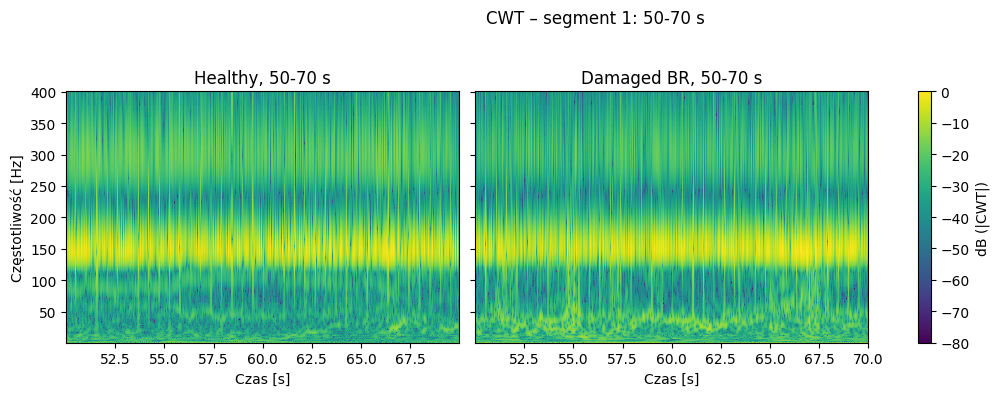

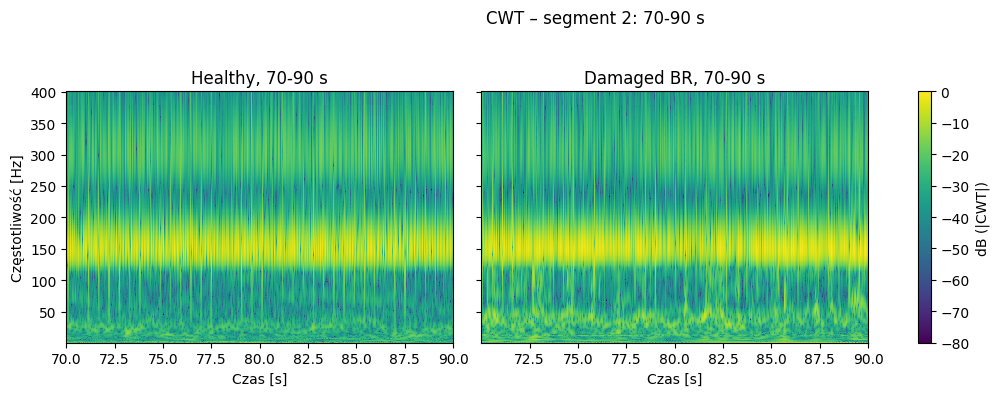

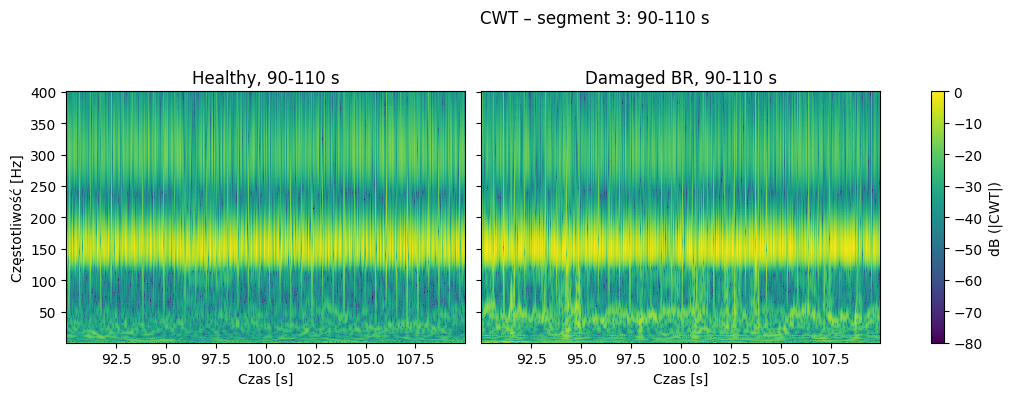

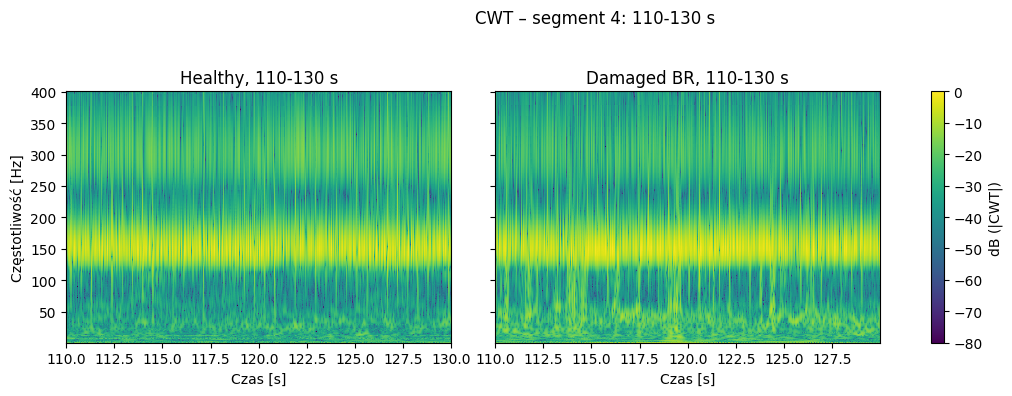

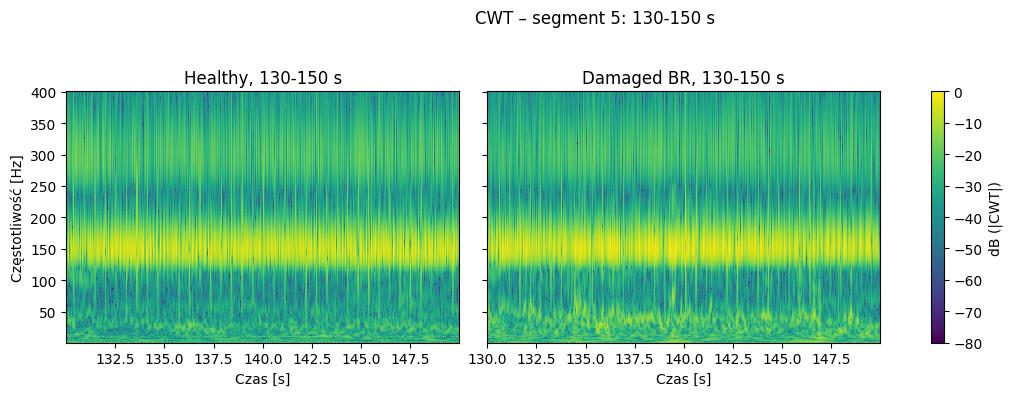

In [4]:
results = {
    "healthy": [],
    "damaged": []
}

for i, (t0, t1) in enumerate(segments, start=1):
    # --- Healthy ---
    t_h, x_h, Fs_h = extract_segment(df_healthy, t0, t1)
    freqs_h, power_db_h = compute_cwt_freq(x_h, Fs_h)

    results["healthy"].append({
        "segment_idx": i,
        "t_range": (t0, t1),
        "t": t_h,
        "Fs": Fs_h,
        "freqs": freqs_h,
        "power_db": power_db_h,
    })

    # --- Damaged ---
    t_d, x_d, Fs_d = extract_segment(df_damaged, t0, t1)
    freqs_d, power_db_d = compute_cwt_freq(x_d, Fs_d)

    results["damaged"].append({
        "segment_idx": i,
        "t_range": (t0, t1),
        "t": t_d,
        "Fs": Fs_d,
        "freqs": freqs_d,
        "power_db": power_db_d,
    })


vmin, vmax = -80, 0

for seg_h, seg_d in zip(results["healthy"], results["damaged"]):
    idx = seg_h["segment_idx"]
    t0, t1 = seg_h["t_range"]

    # dane Healthy
    t_h = seg_h["t"]
    freqs_h = seg_h["freqs"]
    P_h = seg_h["power_db"]

    # dane Damaged
    t_d = seg_d["t"]
    freqs_d = seg_d["freqs"]
    P_d = seg_d["power_db"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # --- CWT Healthy ---
    im0 = axes[0].pcolormesh(
        t_h, freqs_h,
        np.clip(P_h, vmin, vmax),
        shading="auto", vmin=vmin, vmax=vmax
    )
    axes[0].set_title(f"Healthy, {t0}-{t1} s")
    axes[0].set_xlabel("Czas [s]")
    axes[0].set_ylabel("Częstotliwość [Hz]")

    # --- CWT Damaged ---
    im1 = axes[1].pcolormesh(
        t_d, freqs_d,
        np.clip(P_d, vmin, vmax),
        shading="auto", vmin=vmin, vmax=vmax
    )
    axes[1].set_title(f"Damaged BR, {t0}-{t1} s")
    axes[1].set_xlabel("Czas [s]")

    fig.suptitle(f"CWT – segment {idx}: {t0}-{t1} s")
    fig.tight_layout(rect=[0, 0, 0.92, 0.95])

    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), label="dB (|CWT|)")
    plt.show()





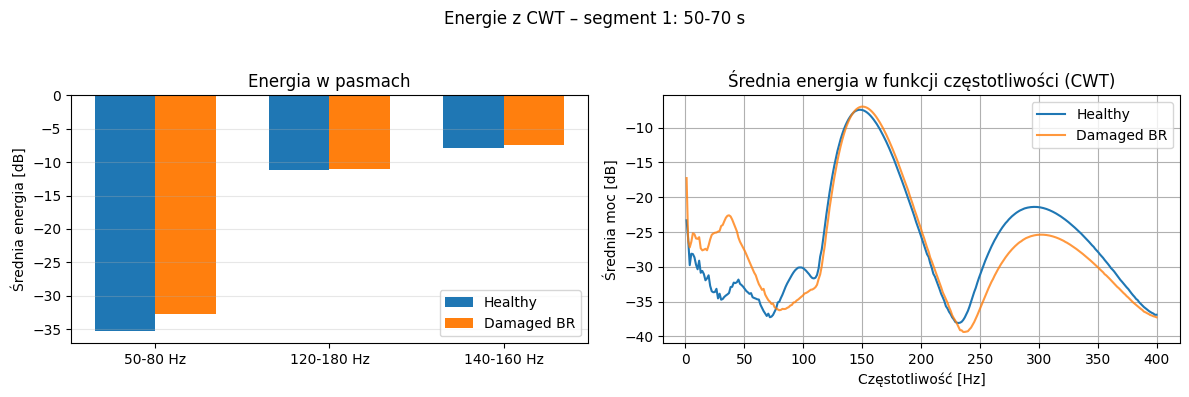

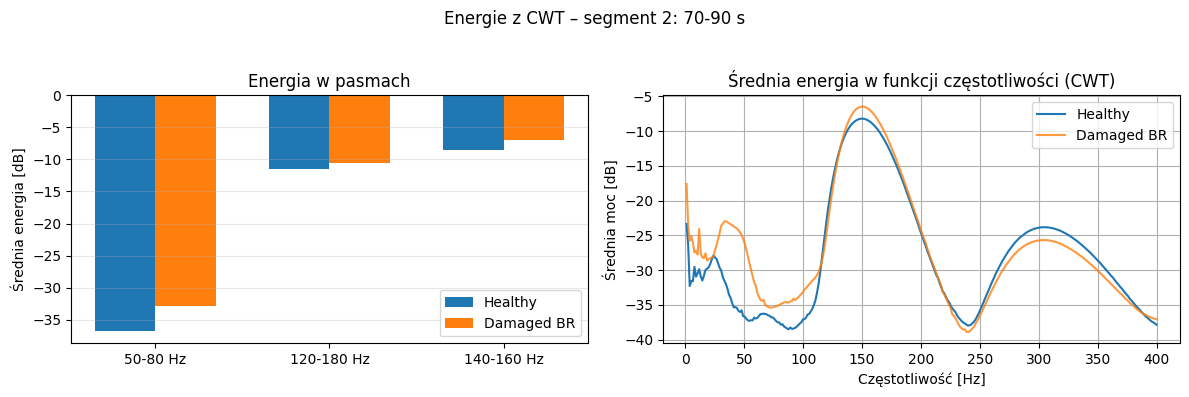

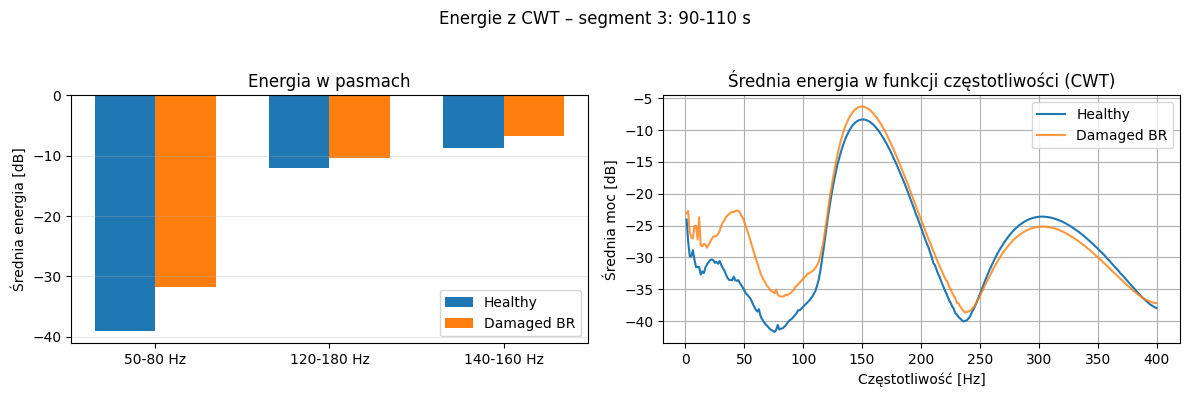

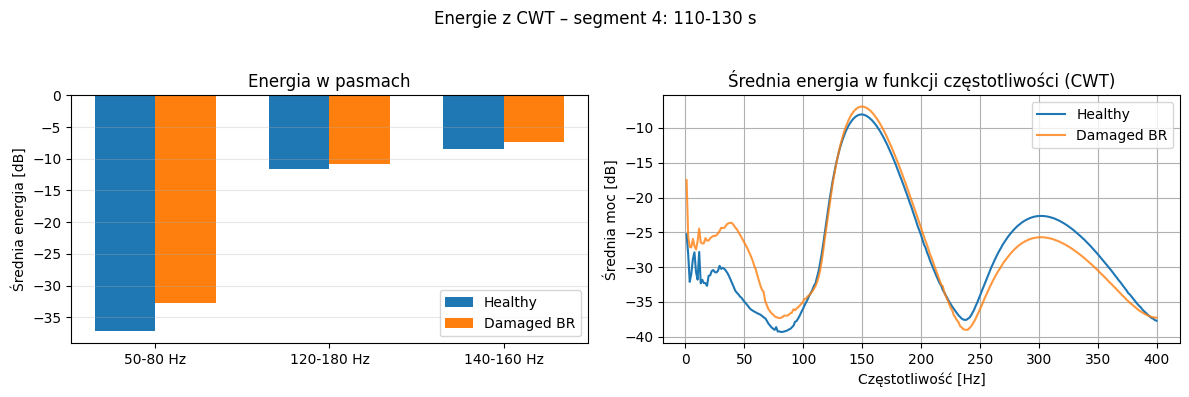

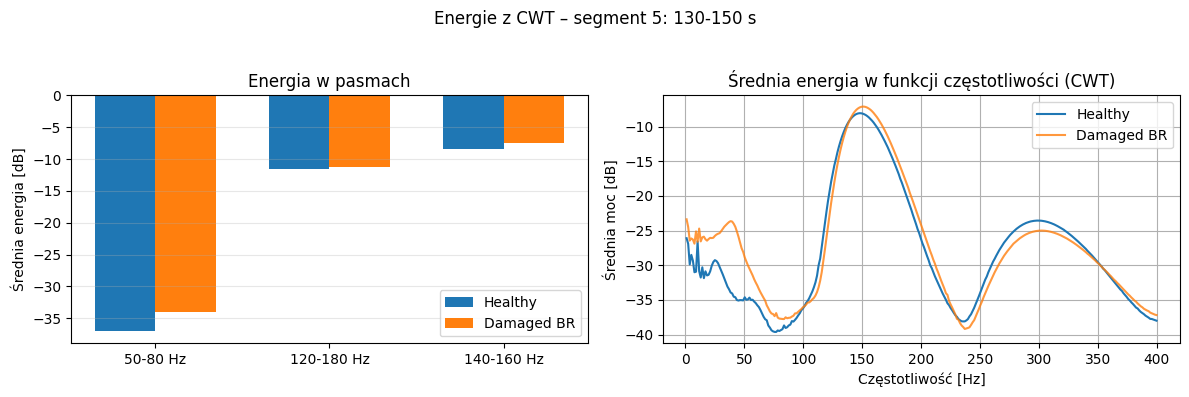

In [5]:
def band_energy_from_cwt(freqs, power_db, f1, f2):
    """
    Średnia energia (w dB) w paśmie [f1, f2] z macierzy CWT (freqs x time).
    """
    mask = (freqs >= f1) & (freqs <= f2)
    if not np.any(mask):
        return np.nan
    return power_db[mask, :].mean()   # średnia po częstotliwości i czasie

bands = [(50, 80), (120, 180), (140, 160)]
band_labels = [f"{f1}-{f2} Hz" for (f1, f2) in bands]


for seg_h, seg_d in zip(results["healthy"], results["damaged"]):
    idx = seg_h["segment_idx"]
    t0, t1 = seg_h["t_range"]

    freqs_h = seg_h["freqs"]
    P_h = seg_h["power_db"]
    freqs_d = seg_d["freqs"]
    P_d = seg_d["power_db"]

    # --- energie w pasmach ---
    E_h = []
    E_d = []
    for (f1, f2) in bands:
        Eh = band_energy_from_cwt(freqs_h, P_h, f1, f2)
        Ed = band_energy_from_cwt(freqs_d, P_d, f1, f2)
        E_h.append(Eh)
        E_d.append(Ed)

    mean_h = P_h.mean(axis=1)
    mean_d = P_d.mean(axis=1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # lewy: słupki energii
    x = np.arange(len(bands))
    w = 0.35
    ax_bar = axes[0]
    ax_bar.bar(x - w/2, E_h, width=w, label="Healthy")
    ax_bar.bar(x + w/2, E_d, width=w, label="Damaged BR")
    ax_bar.set_xticks(x, band_labels)
    ax_bar.set_ylabel("Średnia energia [dB]")
    ax_bar.set_title("Energia w pasmach")
    ax_bar.grid(True, axis="y", alpha=0.3)
    ax_bar.legend()

    # prawy: średnia energia w funkcji częstotliwości
    ax_mean = axes[1]
    ax_mean.plot(freqs_h, mean_h, label="Healthy")
    ax_mean.plot(freqs_d, mean_d, label="Damaged BR", alpha=0.8)
    ax_mean.set_xlabel("Częstotliwość [Hz]")
    ax_mean.set_ylabel("Średnia moc [dB]")
    ax_mean.set_title("Średnia energia w funkcji częstotliwości (CWT)")
    ax_mean.grid(True)
    ax_mean.legend()

    fig.suptitle(f"Energie z CWT – segment {idx}: {t0}-{t1} s")
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



In [6]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis

# --- parametry globalnego pasma do cech widmowych ---
F_GLOBAL_MIN = 0
F_GLOBAL_MAX = 400   # możesz zmienić na 100 jeśli chcesz zawęzić

def extract_features_from_cwt_segment(freqs, power_db, bands,
                                      f_global_min=F_GLOBAL_MIN,
                                      f_global_max=F_GLOBAL_MAX):
    """
    freq: (n_f,)
    power_db: (n_f, n_t) – 20*log10(|coeff|)
    bands: lista (f1,f2) dla pasm cząstkowych

    Zwraca dict z cechami numerycznymi.
    """
    feat = {}

    # --- przygotowanie: przejście na amplitudę liniową ---
    # power_db = 20*log10(A) --> A = 10^(power_db/20)
    A = 10 ** (power_db / 20.0)

    # ---------- CECHY PASMOWE ----------
    for (f1, f2) in bands:
        band_name = f"{f1}_{f2}"

        mask_band = (freqs >= f1) & (freqs <= f2)
        if not np.any(mask_band):
            # brak pokrycia częstotliwości – wypełniamy NaN
            feat[f"band_{band_name}_mean_db"]   = np.nan
            feat[f"band_{band_name}_var_lin"]   = np.nan
            feat[f"band_{band_name}_kurt_lin"]  = np.nan
            feat[f"band_{band_name}_crest_lin"] = np.nan
            continue

        # CWT w dB w tym paśmie
        band_db = power_db[mask_band, :]           # (n_f_band, n_t)
        mean_db = band_db.mean()                   # średnia po f i t

        # CWT w amplitudzie liniowej w tym paśmie
        band_A = A[mask_band, :]                   # (n_f_band, n_t)

        # E_band(t): uśrednienie po częstotliwości -> przebieg w czasie
        E_t = band_A.mean(axis=0)                  # (n_t,)

        # statystyki z E_band(t)
        var_lin  = E_t.var()
        kurt_lin = kurtosis(E_t, fisher=True, bias=False)  # 0 = rozkład normalny
        rms_lin  = np.sqrt((E_t ** 2).mean())
        crest    = E_t.max() / rms_lin if rms_lin > 0 else np.nan

        feat[f"band_{band_name}_mean_db"]   = mean_db
        feat[f"band_{band_name}_var_lin"]   = var_lin
        feat[f"band_{band_name}_kurt_lin"]  = kurt_lin
        feat[f"band_{band_name}_crest_lin"] = crest

    # ---------- CECHY GLOBALNE W PAŚMIE [f_global_min, f_global_max] ----------
    mask_global = (freqs >= f_global_min) & (freqs <= f_global_max)
    if np.any(mask_global):
        freqs_g = freqs[mask_global]
        A_g     = A[mask_global, :]               # (n_f_g, n_t)

        # średnie widmo amplitudowe w czasie
        spec_A_mean = A_g.mean(axis=1)            # (n_f_g,)

        # żeby liczyć centroid/spread/entropię, używamy "mocy" ~ A^2
        P = spec_A_mean ** 2
        P_sum = P.sum()
        if P_sum > 0:
            P_norm = P / P_sum

            # centroid
            f_centroid = np.sum(freqs_g * P_norm)

            # spread (odchylenie std wokół centroidu)
            f_spread = np.sqrt(np.sum(((freqs_g - f_centroid) ** 2) * P_norm))

            # entropia widmowa (naturalny log)
            eps = 1e-12
            spectral_entropy = -np.sum(P_norm * np.log(P_norm + eps))
        else:
            f_centroid = np.nan
            f_spread = np.nan
            spectral_entropy = np.nan
    else:
        f_centroid = np.nan
        f_spread = np.nan
        spectral_entropy = np.nan

    feat["global_centroid"] = f_centroid
    feat["global_spread"]   = f_spread
    feat["global_entropy"]  = spectral_entropy

    return feat


# ===== Ekstrakcja cech dla wszystkich segmentów Healthy / Damaged =====

features = []

# bands i band_labels zakładam, że już zdefiniowałeś wcześniej, np.:
# bands = [(50, 80), (120, 180), (140, 160)]

for cls_label, cls_name in [(0, "healthy"), (1, "damaged")]:
    for seg in results[cls_name]:
        freqs = seg["freqs"]
        power_db = seg["power_db"]

        feat = extract_features_from_cwt_segment(freqs, power_db, bands,
                                                 f_global_min=F_GLOBAL_MIN,
                                                 f_global_max=F_GLOBAL_MAX)
        # metadane
        feat["label"] = cls_label
        feat["class"] = cls_name
        feat["segment_idx"] = seg["segment_idx"]
        feat["t_start"], feat["t_end"] = seg["t_range"]

        features.append(feat)

features_df = pd.DataFrame(features)
features_df


,band_50_80_mean_db,band_50_80_var_lin,band_50_80_kurt_lin,band_50_80_crest_lin,band_120_180_mean_db,band_120_180_var_lin,band_120_180_kurt_lin,band_120_180_crest_lin,band_140_160_mean_db,band_140_160_var_lin,band_140_160_kurt_lin,band_140_160_crest_lin,global_centroid,global_spread,global_entropy,label,class,segment_idx,t_start,t_end
0,-35.341539,0.000171,6.868857,4.155563,-11.103385,0.019798,-0.820823,1.849763,-7.854177,0.039212,-0.793169,1.836598,161.551374,44.423670,4.160331,0,healthy,1,50,70
1,-36.835920,0.000133,10.317359,4.386549,-11.436193,0.016518,-0.794182,1.845798,-8.522140,0.034060,-0.786154,1.847758,159.983292,40.399287,4.120861,0,healthy,2,70,90
2,-39.115044,0.000101,9.143692,4.986846,-12.081500,0.017187,-0.726832,2.017508,-8.704569,0.034808,-0.710453,2.032854,161.960445,42.011933,4.111134,0,healthy,3,90,110
3,-37.237222,0.000107,11.220789,4.788801,-11.650444,0.017137,-0.643360,2.040630,-8.448667,0.034454,-0.641995,2.042812,161.564979,43.203040,4.143102,0,healthy,4,110,130
4,-37.080700,0.000113,8.852229,4.276928,-11.600965,0.017897,-0.685945,1.998056,-8.492455,0.036164,-0.665998,1.983934,158.773322,40.133334,4.094522,0,healthy,5,130,150
5,-32.728570,0.000954,4.384173,4.706201,-11.030585,0.019175,-0.483085,2.075732,-7.391471,0.037670,-0.518195,2.003368,154.401343,39.327999,4.101097,1,damaged,1,50,70
6,-32.911876,0.001221,6.707853,5.711595,-10.598275,0.016691,-0.537072,1.942934,-6.894154,0.032873,-0.544718,1.882970,154.075885,37.990468,4.081820,1,damaged,2,70,90
7,-31.794014,0.001384,7.936982,5.375196,-10.391579,0.016538,-0.589620,1.864997,-6.731069,0.032794,-0.579570,1.814096,154.557204,37.812322,4.089904,1,damaged,3,90,110
8,-32.785166,0.001823,6.726005,5.012723,-10.905680,0.017388,-0.509113,1.964931,-7.347745,0.034523,-0.534259,1.925408,153.863386,38.774454,4.109994,1,damaged,4,110,130
9,-34.006755,0.000774,7.699250,4.642881,-11.310297,0.018452,-0.627662,1.969692,-7.563070,0.036343,-0.632317,1.953791,156.234699,39.382621,4.098163,1,damaged,5,130,150
